<a href="https://colab.research.google.com/github/cauarichard/crud2/blob/main/C%C3%B3pia_de_separacaodinov2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip


/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth


100%|██████████| 84.2M/84.2M [00:00<00:00, 237MB/s]


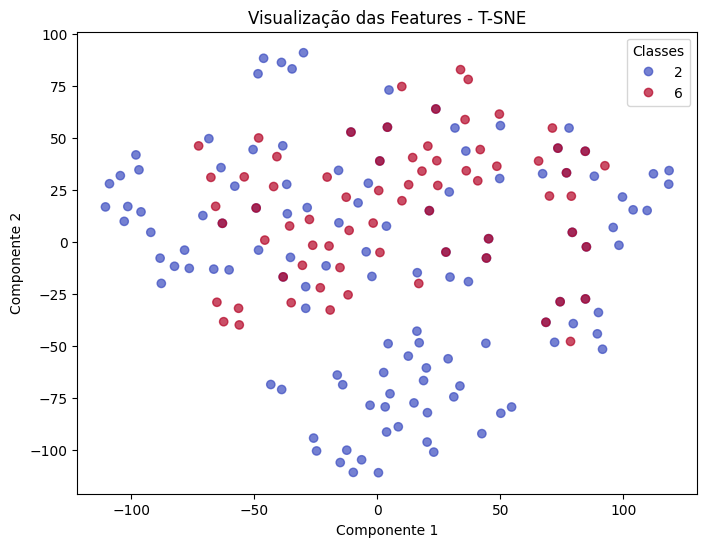

In [ ]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from sklearn.manifold import TSNE
from PIL import Image
from torch.utils.data import Dataset, DataLoader, Subset
import cv2
from google.colab import drive
import torch.nn as nn

# 1) Monta o Google Drive para acessar as imagens
drive.mount('/content/drive')

# 2) Definir caminhos das pastas
BASE_PATH = '/content/drive/MyDrive/dataset/real_fake'
FAKES_FOLDER = 'faces_fake_completada'
REALS_FOLDER = 'faces_real_completada'

# 3) Função de loader OpenCV para evitar problemas com metadados JPEG
def opencv_loader(path):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return Image.fromarray(img)

# 4) Transformações de pré-processamento para as imagens
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensiona para 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

# 5) Carregar as imagens da pasta fake e real
full_dataset = datasets.ImageFolder(root=BASE_PATH, transform=transform, loader=opencv_loader)

# Filtrar pelas pastas desejadas
indices = [i for i, (_, label) in enumerate(full_dataset.samples)
           if full_dataset.classes[label] in ['faces_fake_completada', 'faces_real_completada']]

# Criar o dataset binário
binary_ds = Subset(full_dataset, indices)

# 6) Carregar o modelo DINOv2
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dinov2 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14", pretrained=True).to(DEVICE)

class DinoClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.classifier = nn.Sequential(
            nn.Linear(384, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )
    def forward(self, x):
        with torch.no_grad():
            features = dinov2.forward_features(x)["x_norm_clstoken"]
        return features

model = DinoClassifier().to(DEVICE)

# 7) Função para extrair as features
def extract_features(dataset, model, device):
    model.eval()
    features, labels = [], []
    with torch.no_grad():
        for img, label in dataset:
            img = img.unsqueeze(0).to(device)
            feature = model(img)
            features.append(feature.cpu().numpy())
            labels.append(label)
    return np.concatenate(features), np.array(labels)

# 8) Extrair features
features, labels = extract_features(binary_ds, model, DEVICE)

# 9) Aplicar T-SNE
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(features)

# 10) Visualizar os resultados com T-SNE
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='coolwarm', alpha=0.7)
plt.title("Visualização das Features - T-SNE")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.show()

Classe 2 é a real -  Classe 6 é a Falsa